In [ ]:
%pip install -q -U datasets evaluate accelerate python-iso639

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Make sure to mount Google Drive at `/content/drive`.

Also make sure the util scripts are added to the path that is used in `sys.path.append`.

In [ ]:
from dataclasses import dataclass, asdict
from typing import Any
import datetime
import sys

import datasets
import transformers
from transformers import AutoModel, Trainer, AutoModelForAudioClassification, TrainingArguments, AutoFeatureExtractor
from torch.utils.data import DataLoader
import torch
import evaluate
from tqdm.auto import trange, tqdm
import numpy as np
import iso639
import matplotlib.pyplot as plt

sys.path.append("/content/drive/MyDrive/Colab Notebooks/")
import global_id_utils

In [ ]:
timestamp_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = "/content/drive/MyDrive/LangId Evaluation/minds-14_wav2vec2-base-lang-id/" + timestamp_str + "/"

# Load model

In [ ]:
model_id = "anton-l/wav2vec2-base-lang-id"
model = AutoModelForAudioClassification.from_pretrained(model_id)
# model.to_bettertransformer()
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at anton-l/wav2vec2-base-lang-id were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at anton-l/wav2vec2-base-lang-id and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embe

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Create mappings to/from model ids to global ids to make using other datasets on this model easier. We create a common interface that allows translation to a single target.

<small>This model has a lot of typos for some reason</small>

In [ ]:
modified_id2label = model.config.id2label.copy()
# Original: Chinese_China
modified_id2label[4] = "cmn"
# Original: Chinese_HongKong
modified_id2label[5] = "yue"
# Original: Chinese_Taiwan
modified_id2label[6] = "cmn"
# Original: Frisian. Assuming that this refers to Western Frisian
modified_id2label[15] = "fry"
# Original: Greek. Need to distinguish between Ancient and Modern Greek
modified_id2label[18] = "ell"
# Original: Hakha_Chin
modified_id2label[19] = "hak"
# Original: Interlingua
modified_id2label[21] = "ina"
# Original: "Mangolian". I assume a typo
modified_id2label[29] = "Mongolian"
# Original: Sakha
modified_id2label[36] = "sah"
# Original: Ukranian. Another typo I assume
modified_id2label[43] = "Ukrainian"

In [ ]:
model_id_to_global_id = {
    model_id: global_id_utils.language_to_global_id(modified_id2label[model_id].split("_")[0])
    for model_id in model.config.id2label
}

In [ ]:
global_id_to_model_id = {v:k for k, v in model_id_to_global_id.items()}

# Load and preprocess data

In [ ]:
# On Google Colab cpu, runs at about 0.04 it/s, so 200 will over 1.25 hours
minds_14 = datasets.load_dataset("PolyAI/minds14", "all", split="train").shuffle(seed=42).select(range(100))
minds_14

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 100
})

The label names in minds14 are ISO 639-1 codes with the locale (country) afterwards, separated by a hyphen ("en-us"). We take just the language code and use that to create the global id.

The label for Chinese Mandarin in `minds14` is "zh" while the label in the model is "cmn". Add a custom mapping to fix that discrepency.

In [ ]:
minds_int2str = minds_14.features["lang_id"]._int2str
minds_str2int = minds_14.features["lang_id"]._str2int

In [ ]:
dataset_id_to_global_id = {
    dataset_id: global_id_utils.iso639_part3_to_global_id(
        iso639.Language.from_part1(minds_int2str[dataset_id].split("-")[0]).part3)
    for dataset_id in minds_14.features["lang_id"]._str2int.values()
}
dataset_id_to_global_id[minds_str2int["zh-CN"]] = global_id_utils.iso639_part3_to_global_id("cmn")

Verify that all dataset languages map to a language in the model.

Todo: Check if Chinese mappings to Chinese_Taiwan vs Chinese_Mandarin has impact on performance.

In [ ]:
for name in minds_14.features["lang_id"].names:
  dataset_id = minds_14.features["lang_id"]._str2int[name]
  global_id = dataset_id_to_global_id[dataset_id]
  if global_id not in global_id_to_model_id:
    print(f"Warning: The language {name} (id {dataset_id}) in the dataset does not map to an id in the model."
    + "\nAdd a custom entry to the global_id_to_model_id dictionary")

Add a custom entry to the global_id_to_model_id dictionary


The model doesn't seem to be trained on Korean. Remove those rows from the dataset

In [ ]:
ko_KR_dataset_id = 8

In [ ]:
minds_14 = minds_14.filter(lambda sample: sample["lang_id"] != ko_KR_dataset_id)

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
minds_14 = minds_14.remove_columns(["path", "transcription", "english_transcription", "intent_class"])

In [ ]:
minds_14 = minds_14.cast_column("audio", datasets.Audio(sampling_rate=16000))

In [ ]:
def preprocess(sample):
  new_sample = feature_extractor(sample["audio"]["array"], sampling_rate=16_000, return_tensors="pt")
  # TODO: Don't hard code feature extractor output key names
  new_sample["input_values"] = torch.squeeze(new_sample["input_values"])
  global_id = dataset_id_to_global_id[sample["lang_id"]]
  new_sample["label"] = global_id_to_model_id[global_id]
  return new_sample

In [ ]:
minds_14 = minds_14.map(preprocess, batched=False, remove_columns=["audio"])

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

In [ ]:
sample = next(iter(minds_14))
sample.keys()

dict_keys(['lang_id', 'input_values', 'label'])

# Make inferences

In [ ]:
args = TrainingArguments(
    output_dir=output_dir,
    per_device_eval_batch_size=1,
    logging_steps=25,
    jit_mode_eval=True,
)

In [ ]:
trainer = Trainer(
    args=args,
    model=model,
    eval_dataset=minds_14,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
# eval_results = trainer.evaluate()
# eval_results

In [ ]:
%%time
prediction_output = trainer.predict(minds_14)
prediction_output

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:594: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:633: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace mig

CPU times: user 5min 8s, sys: 42.7 s, total: 5min 50s
Wall time: 5min 59s


PredictionOutput(predictions=array([[ -9.723239  ,   0.30511913,  -6.362174  , ...,   1.4340572 ,
          2.6139846 ,  -3.8892443 ],
       [ -3.4752774 ,  10.206206  ,  -7.989941  , ...,  -0.73972315,
         -2.527891  ,  -2.7452793 ],
       [ -1.699669  ,   9.243714  ,  -4.8131866 , ...,   3.8876524 ,
         -6.460022  ,  -0.65809304],
       ...,
       [  1.4579463 ,  -2.0538154 ,  -1.5494102 , ...,   9.188     ,
         -2.3484879 ,  -6.2300153 ],
       [  7.015303  ,  -4.706147  ,  -1.9908414 , ...,  -1.2428149 ,
        -11.778881  ,   8.068509  ],
       [ -3.8813272 ,  -5.9001675 ,  -0.07453126, ...,   4.1089873 ,
          5.8092513 ,  -7.6452203 ]], dtype=float32), label_ids=array([22, 22, 35, 14, 11, 31, 10,  8, 11, 17, 31, 11, 32, 14,  6, 32, 11,
       35, 11, 35, 14, 11, 17, 14, 10, 10, 10,  8, 11, 14, 22, 11, 11, 31,
        8,  8,  8, 11, 31, 11,  8, 32, 17, 38, 31, 17,  6, 38, 11, 10, 14,
       32, 17, 11, 31,  8, 32, 11, 11, 31, 11, 10, 35, 35,  6, 31, 11, 

# Evaluate

In [ ]:
import eval_report

                  precision    recall  f1-score   support

Mandarin Chinese       1.00      0.67      0.80         3
           Czech       0.75      0.38      0.50         8
           Dutch       0.83      0.56      0.67         9
         English       0.86      0.63      0.73        19
          French       0.88      0.78      0.82         9
          German       0.83      0.71      0.77         7
         Italian       0.75      0.50      0.60         6
          Polish       1.00      0.30      0.46        10
      Portuguese       0.83      0.50      0.62        10
         Russian       0.56      0.71      0.63         7
         Spanish       0.50      0.50      0.50         4

       micro avg       0.79      0.57      0.66        92
       macro avg       0.80      0.57      0.65        92
    weighted avg       0.82      0.57      0.65        92



/content/drive/MyDrive/Colab Notebooks/eval_report.py:84: RuntimeWarning: invalid value encountered in divide
  accuracy = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


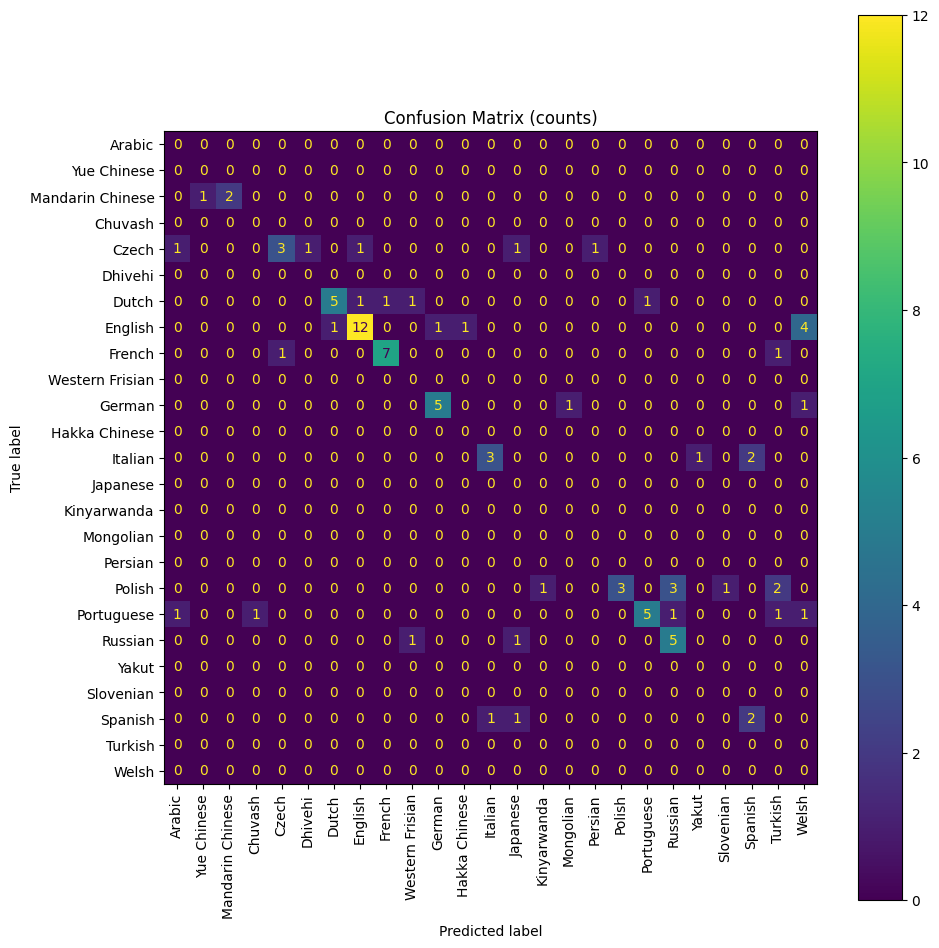

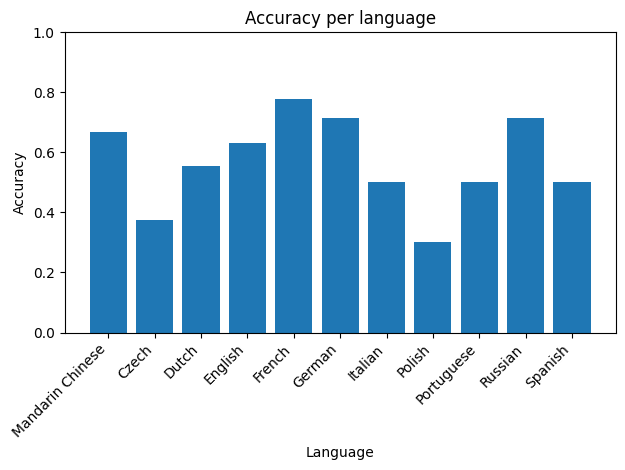

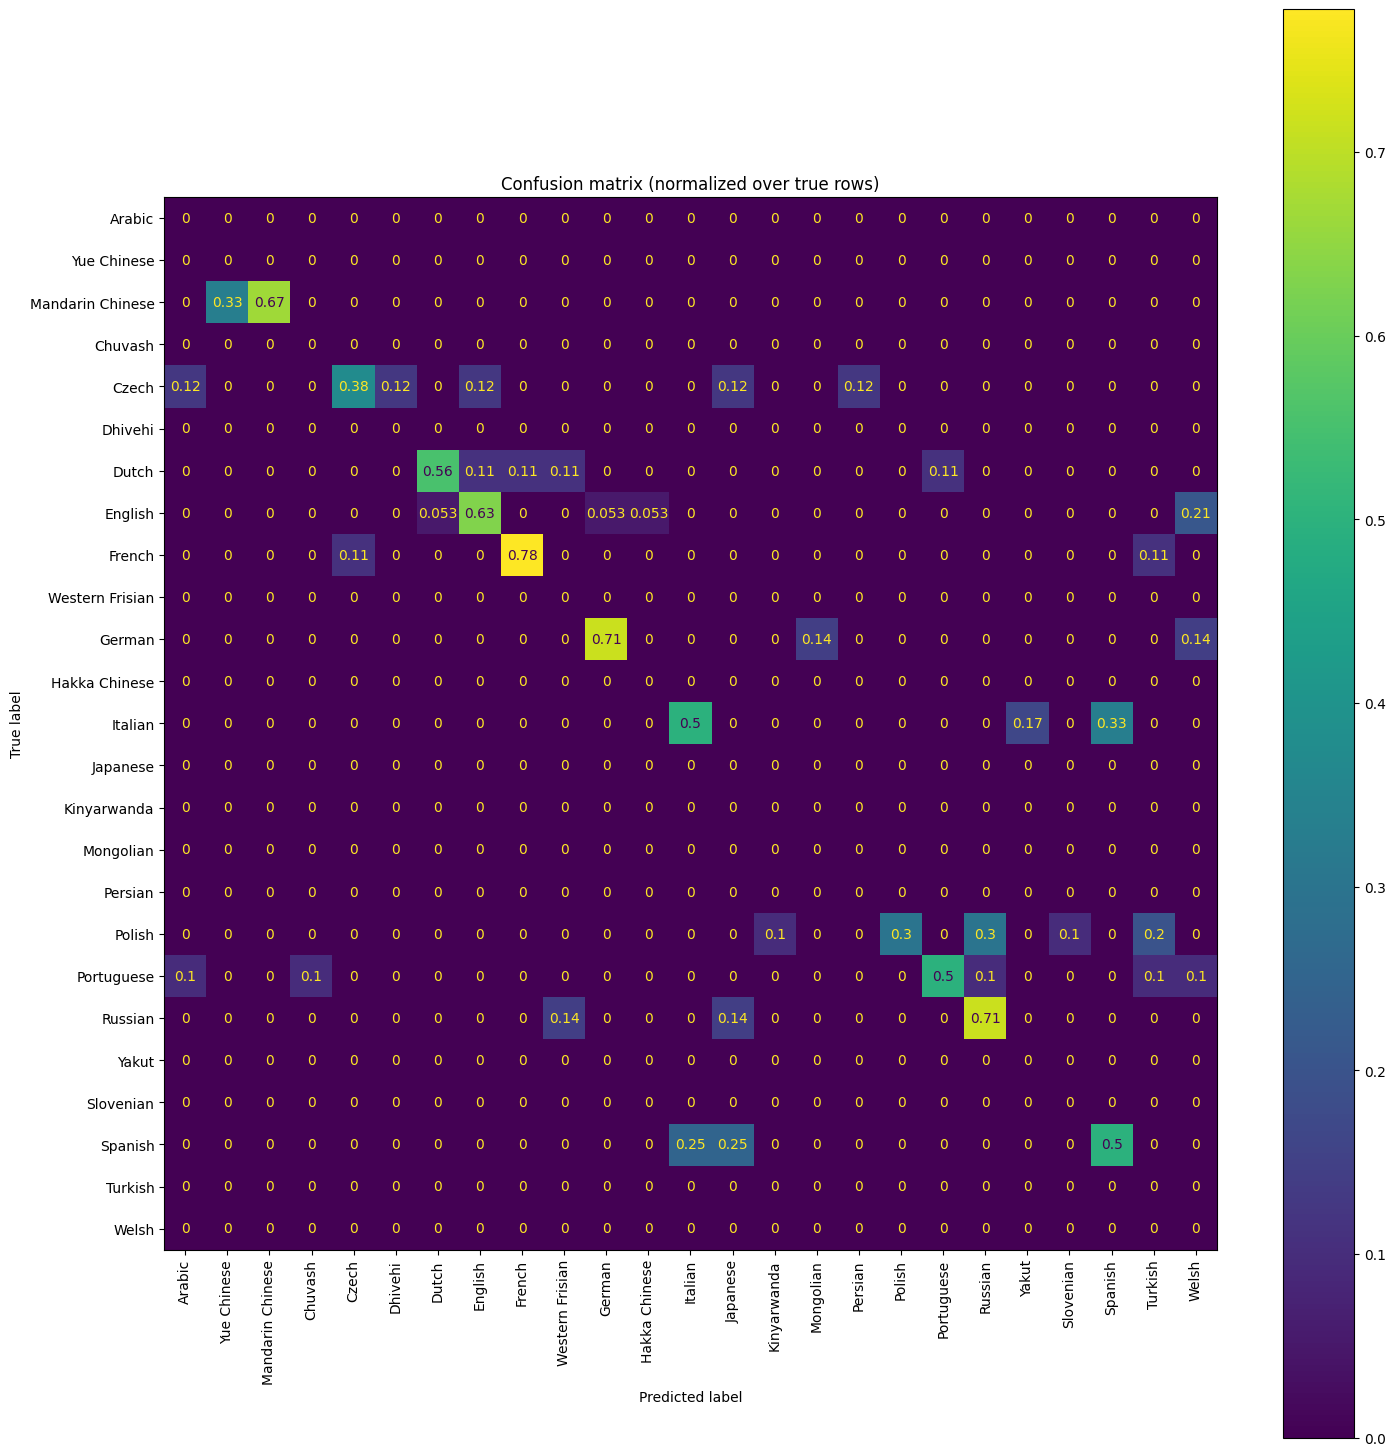

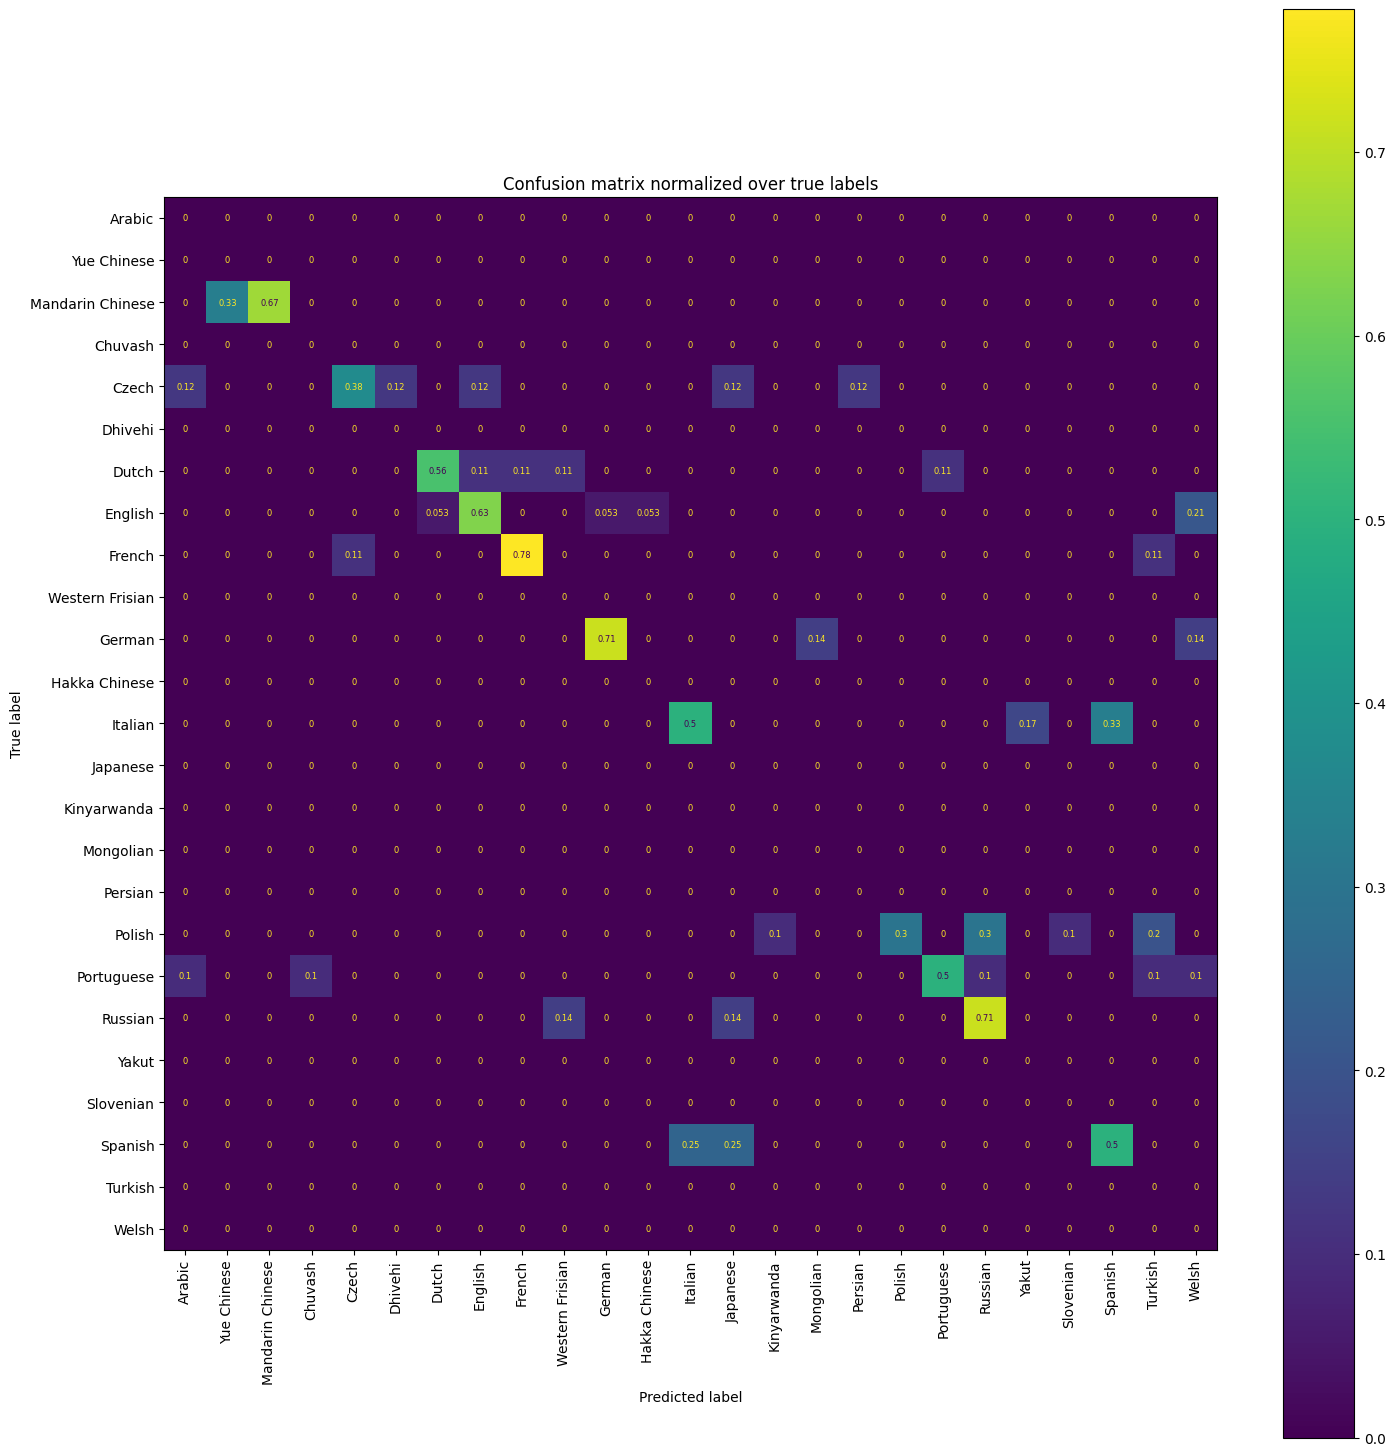

In [ ]:
eval_report.make_evaluation_outputs(prediction_output, output_dir, model_id_to_global_id, model.config.id2label, dataset_id_to_global_id)

In [ ]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4400.44
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i